# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

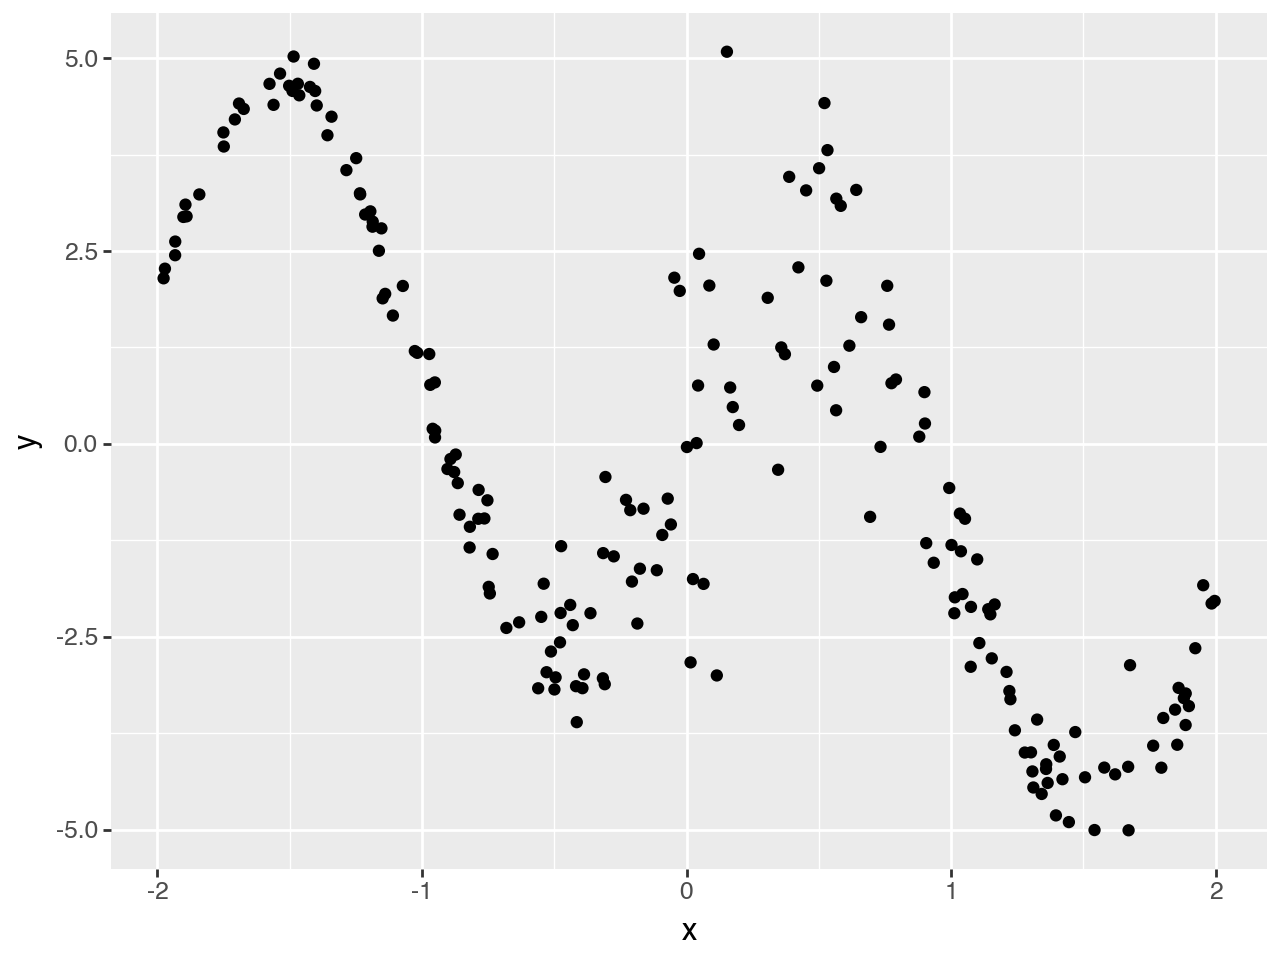

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)

loc += tb.ps("x")
scale += tb.ps("x")

### Build and plot model

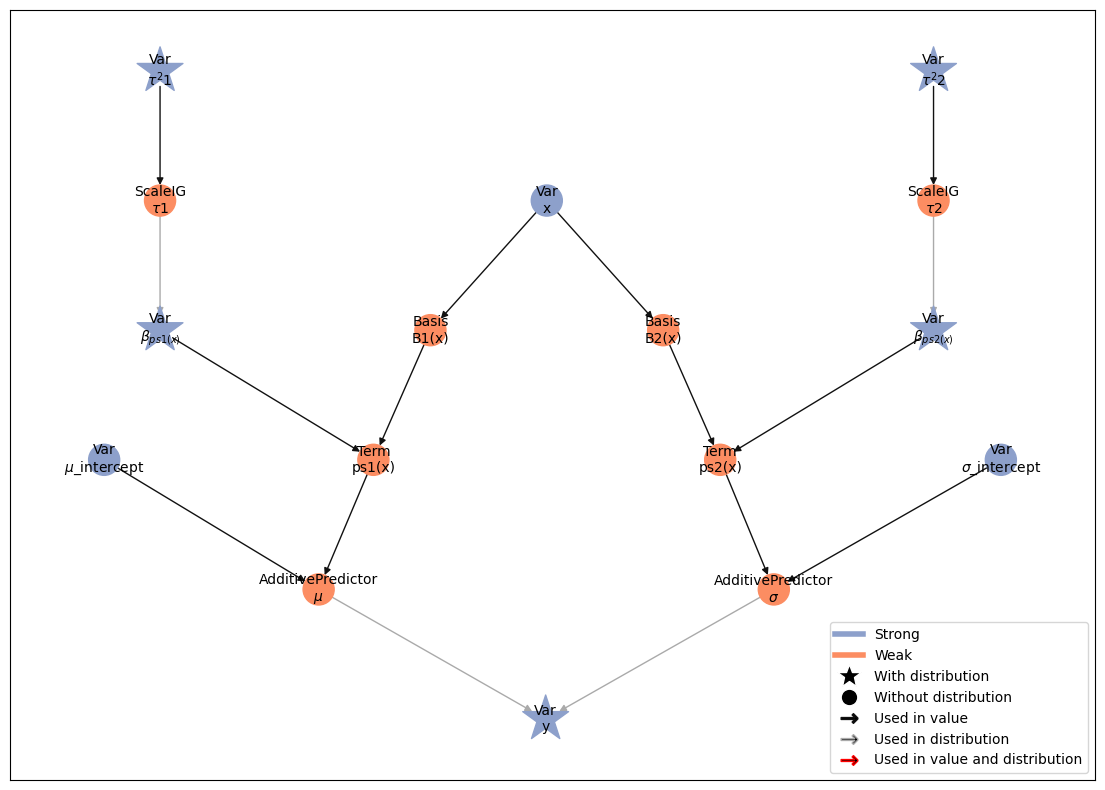

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{ps2(x)}$', '$\\tau^2$2', '$\\mu$_intercept', '$\\beta_{ps1(x)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.70chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 986.20chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1195.47chunk/s]
liesel.goose.engine - INFO - Finished epoch
l

### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_04 -0.246338  0.409549 -0.921900 -0.237391   
                   (1,)   kernel_04 -0.018005  0.373481 -0.625266 -0.022235   
                   (2,)   kernel_04  0.396644  0.385096 -0.200192  0.384781   
                   (3,)   kernel_04  0.172166  0.368702 -0.428567  0.158761   
                   (4,)   kernel_04  0.141034  0.342288 -0.400390  0.136629   
                   (5,)   kernel_04  0.163197  0.323979 -0.352560  0.160050   
                   (6,)   kernel_04  0.007890  0.315641 -0.503610  0.002345   
                   (7,)   kernel_04 -0.066754  0.284300 -0.538742 -0.064970   
                   (8,)   kernel_04  0.067715  0.278466 -0.383755  0.063318   
                   (9,)   kernel_04  0.107465  0.242768 -0.283381  0.104773   
                   (10,)  kernel_04  0.138718  0.229533 -0.245854  0.146975   
                   (11,)  kernel_04 -0.119842  0.197867 -0.448976 -0.117983   
                   (12,)  kernel_04  0.313453  0.172938  0.033541  0.315019   
                   (13,)  kernel_04 -0.048405  0.137289 -0.268221 -0.052678   
                   (14,)  kernel_04  1.348600  0.105915  1.180180  1.347265   
                   (15,)  kernel_04  0.035859  0.070630 -0.078640  0.034878   
                   (16,)  kernel_04  0.120161  0.039881  0.055695  0.120224   
                   (17,)  kernel_04  0.014284  0.016580 -0.012595  0.014168   
                   (18,)  kernel_04 -0.316101  0.062329 -0.418292 -0.315983   
$\beta_{ps2(x)}$   (0,)   kernel_01 -0.005792  0.085773 -0.145186 -0.005057   
                   (1,)   kernel_01  0.009809  0.085013 -0.122598  0.008202   
                   (2,)   kernel_01 -0.001595  0.083082 -0.135327 -0.002136   
                   (3,)   kernel_01  0.001290  0.080653 -0.126951  0.000900   
                   (4,)   kernel_01 -0.014581  0.081872 -0.154099 -0.012050   
                   (5,)   kernel_01  0.006605  0.081934 -0.123626  0.004528   
                   (6,)   kernel_01  0.017061  0.081832 -0.110522  0.014349   
                   (7,)   kernel_01 -0.031047  0.082055 -0.177473 -0.025186   
                   (8,)   kernel_01  0.024983  0.078979 -0.100503  0.022851   
                   (9,)   kernel_01  0.000742  0.074666 -0.121503 -0.000043   
                   (10,)  kernel_01 -0.007115  0.071337 -0.121409 -0.007465   
                   (11,)  kernel_01 -0.004884  0.066967 -0.115990 -0.005135   
                   (12,)  kernel_01  0.079193  0.067793 -0.022267  0.075454   
                   (13,)  kernel_01 -0.081606  0.059648 -0.186593 -0.078772   
                   (14,)  kernel_01  0.055700  0.050081 -0.024467  0.054621   
                   (15,)  kernel_01  0.081976  0.036388  0.023699  0.081313   
                   (16,)  kernel_01 -0.003116  0.022086 -0.039213 -0.002989   
                   (17,)  kernel_01 -0.043626  0.009757 -0.059185 -0.043824   
                   (18,)  kernel_01  0.142807  0.038504  0.078538  0.142954   
$\mu$_intercept    ()     kernel_03 -0.321852  0.057602 -0.416376 -0.323591   
$\sigma$_intercept ()     kernel_00 -0.631457  0.052969 -0.716864 -0.633095   
$\tau^2$1          ()     kernel_05  0.198259  0.094189  0.096203  0.177555   
$\tau^2$2          ()     kernel_02  0.007012  0.005363  0.002198  0.005613   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\beta_{ps1(x)}$   (0,)   0.415031         4000  3233.137474  3729.229058   
                   (1,)   0.579171         4000  3588.352862  3682.445835   
                   (2,)   1.058880         4000  3209.292484  3627.967087   
                   (3,)   0.783245         4000  3531.509312  3581.158809   
                   (4,)   0.713792       

### MCMC trace plots

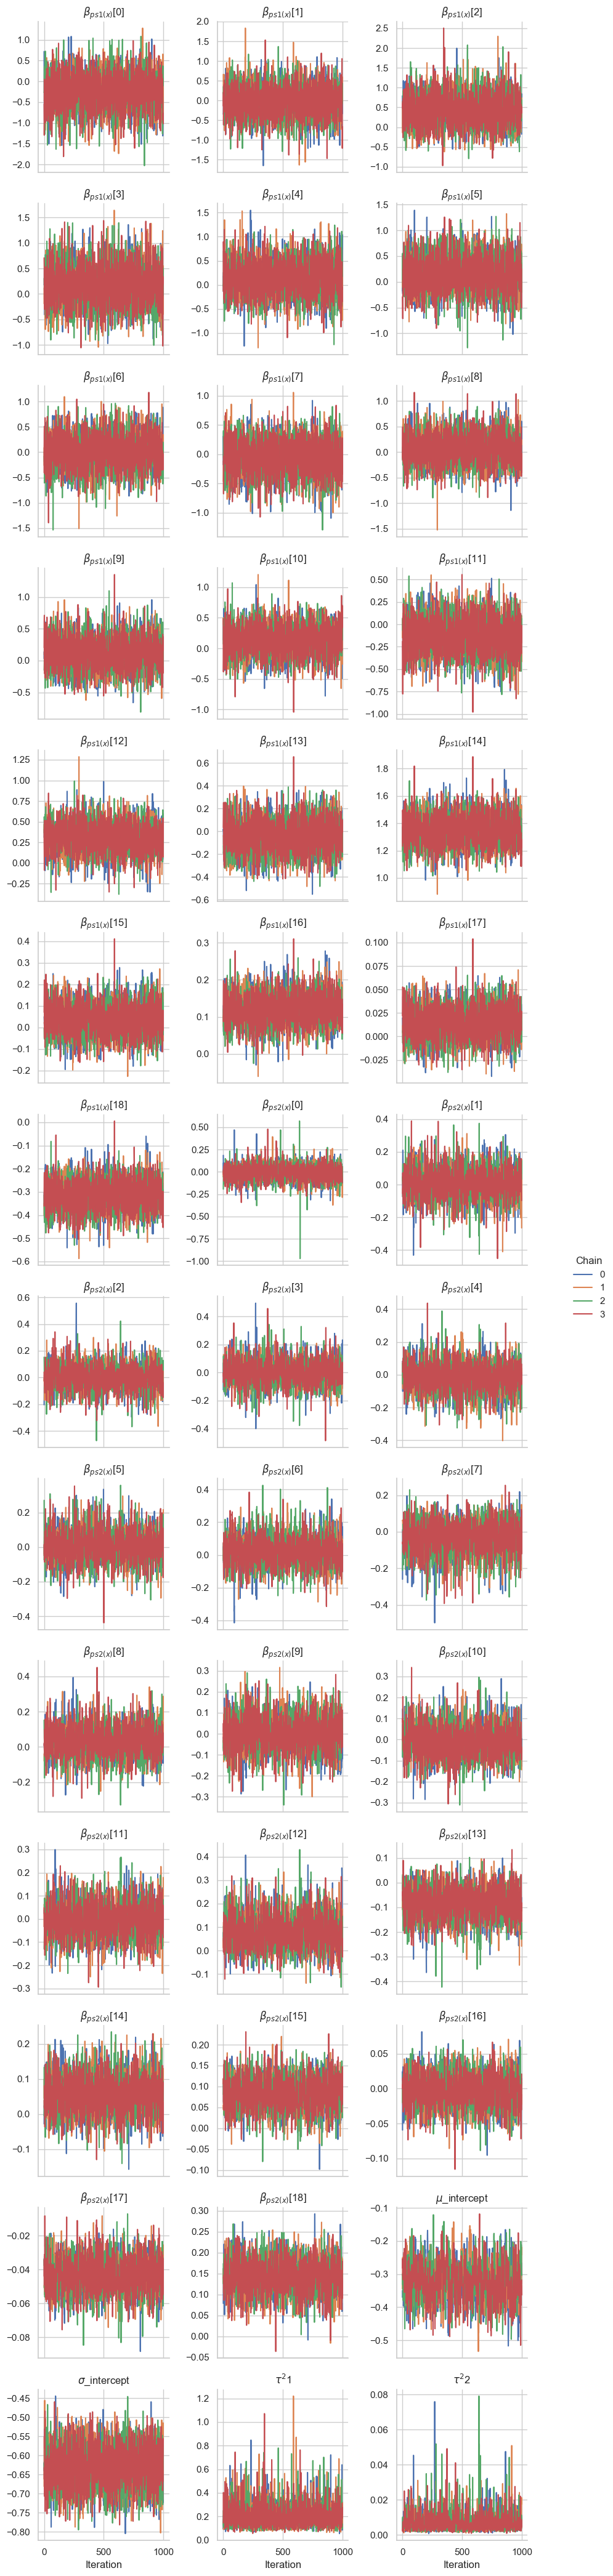

In [8]:
gs.plot_trace(results)

## Predictions

In [9]:
samples = results.get_posterior_samples()

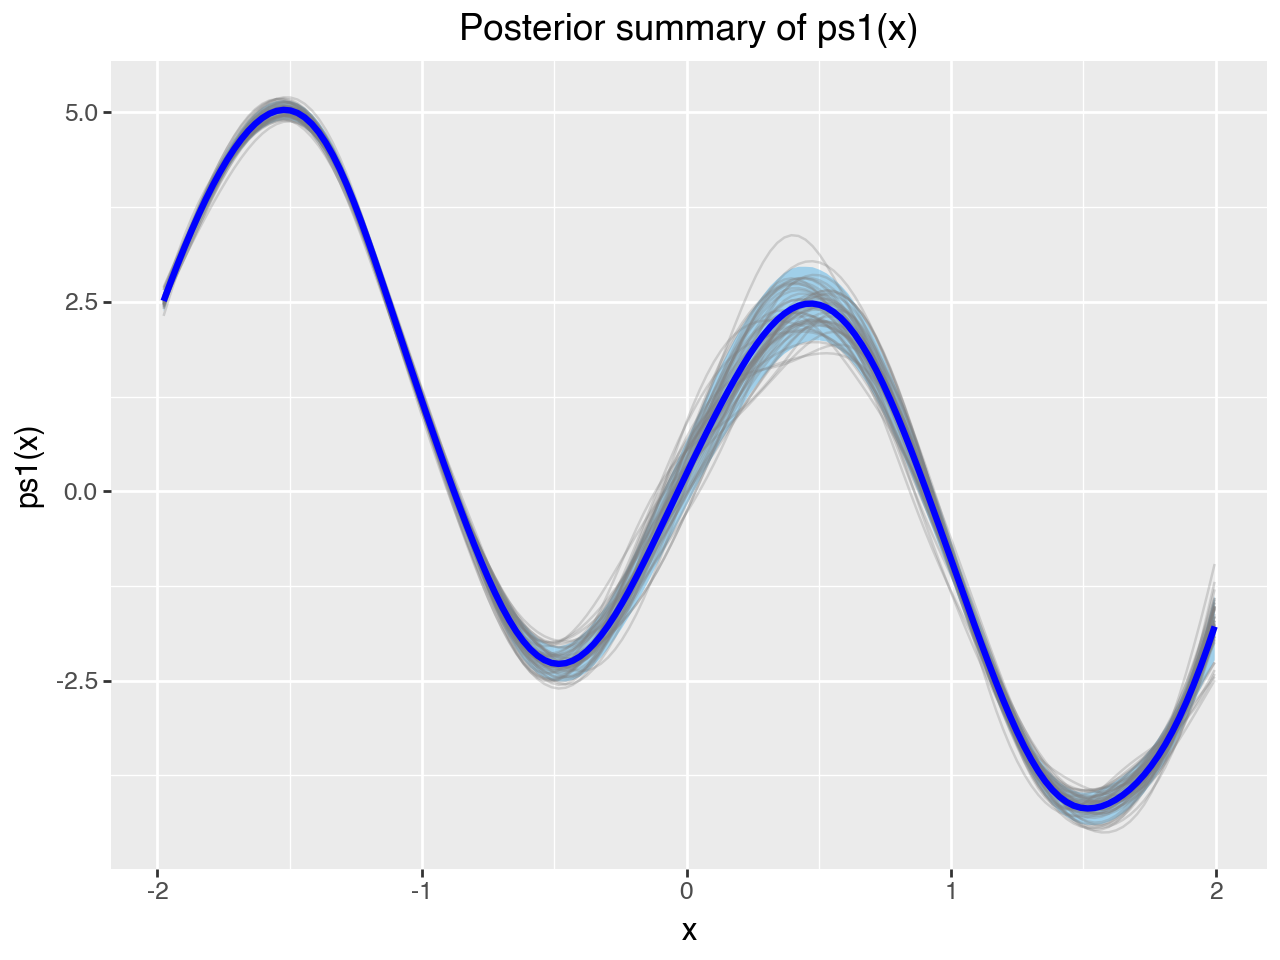

In [10]:
gam.plot_1d_smooth(term=model.vars["ps1(x)"], samples=samples)

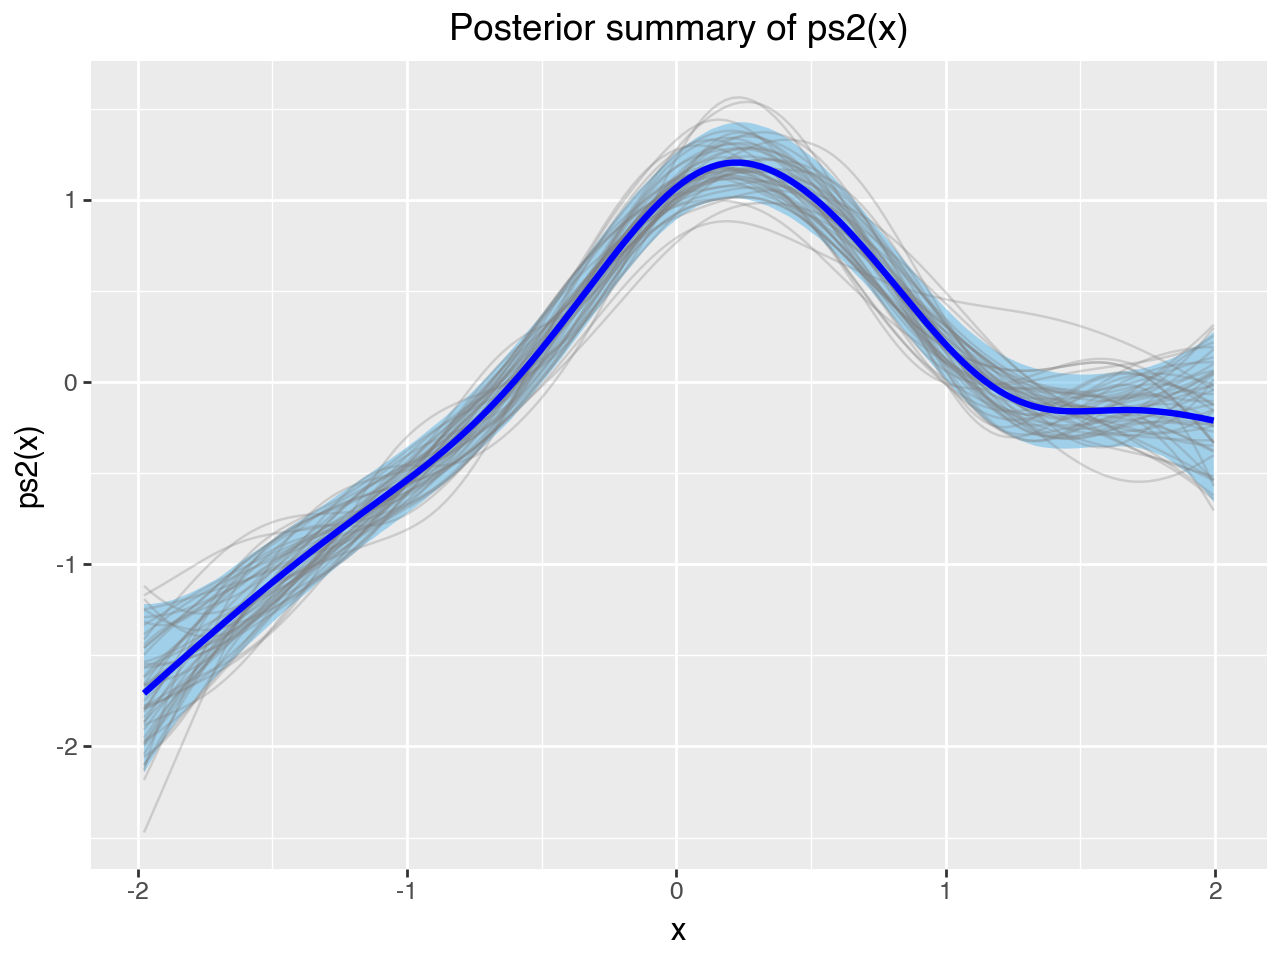

In [11]:
gam.plot_1d_smooth(term=model.vars["ps2(x)"], samples=samples)